# Predicting Star Ratings of Edinburgh Airbnbs through Review Texts Analysis

# Notebook 4: Modelling_Review_Uncollapsed

In this notebook, we will further process our Airbnb reviews using natural language processing (NLP) and machine learning techniques. We will first define a customized tokenizer to remove any irrelevant contents from the text and separate the review texts into individual words. Next, we will set up for modelling stage including define the Baseline Score for future model evaluation.  After that, we will utilize different machine learning models and attempt to find the best-performing models by tuning hyperparameters using GridSearch. Finally, we will use evaluation metrics to assess our results.

**Note**: The review data used in this notebook is the cleaned and processed review dataset with listing information aggregated to each review. The reviews are **not collapsed** to each Airbnb Listing.

***

# Table of Contents

1. [**Import Libraries**](#a1)<br>

2. [**Customized Tokenizer**](#a2)<br>
    
3. [**Modelling Set Up**](#a3)<br>
    3.1.[Split Variables](#a3.1)<br>
    3.2.[Target Varaible Distribution](#a3.2)<br>
    3.3.[Train Test Split](#a3.3)<br>
    3.4.[Sampling](#a3.4)<br>
    3.5.[Helper Function](#a3.5)<br>
        
4. [**Baseline Model**](#a4)<br>
    4.1.[Baseline Model Evaluation](#a4.1)<br>
5. [**Modelling**](#a5)<br>
    5.1.[GridSearch_1: Genearl Sweep](#a5.1)<br>

***

## Import Libraries <a id='a1'></a>

In [1]:
# Main Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scipy Library for sparse  matrix
from scipy.sparse import csr_matrix

# NLP Libraries
import nltk
import re
import string
import html
import contractions
import langid
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from langid.langid import LanguageIdentifier

# Download from nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Feature Extraction Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Dummy Classifer 
from sklearn.dummy import DummyClassifier

# Modelling Libraries
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Evaluation Libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12276\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\12276\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Loading Relevant Data

In [2]:
# Load uncollapsed review data
df_reviews_by_listing= joblib.load('data/df_reviews_by_listing.pkl')

#### Ignore userwarnings

In [3]:
import warnings

# Ignore UserWarning
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

***

# Customized Text Tokenizer <a id='a2'></a>

Our ultimate goal is to use machine learning models to accurately predict guests' sentiment scores, determining whether they will give a rating of over 4.8 or not. To enable the models to comprehend the review texts, we must first separate the documents into individual tokens. This task requires defining various tokenizing requirements to remove irrelevant text components from the data. Therefore, our customized text tokenizer should be able to:
- Lowercase text
- Remove punctuations
- Remove Whitespaces
- Remove HTML white spaces of format <br/>
- Remove emails
- Remove emojis
- Remove English Stop words
- Remove special characters
- Remove numbers
- Remove weblinks
- Expand contractions
- Remove Non-English Text Characters (Mixed with English review that was not detected and filtered in the pre-processing stage)
- Perfome Texts Lemmatization (each word is mapped to a fixed, meaningful common root form)

In [4]:
def customized_tokenizer(sentence):
    
    # Remove HTML tags and entities
    sentence = html.unescape(sentence)
    sentence = re.sub(r'<[^>]+>', '', sentence)
    
    # Remove HTML white spaces \r<br/> and <br/>
    sentence = re.sub(r'(\r<br/>)|(<br/>)', ' ', sentence)
    
    # Remove punctuations
    sentence = re.sub(r'[^\w\s]', '', sentence)
    
    # Lowercase text
    sentence = sentence.lower()
    
    # Remove whitespaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Remove emails
    sentence = re.sub(r'\S*@\S*\s?', '', sentence)
    
    # Remove emojis
    sentence = sentence.encode('ascii', 'ignore').decode('ascii')
    
    # Remove special characters
    sentence = re.sub(r'[^A-Za-z\s]', '', sentence)
    
    # Remove numbers
    sentence = re.sub(r'[0-9]+', '', sentence)
    
    # Remove weblinks
    sentence = re.sub(r'http\S+', '', sentence)
    
    # Expand contractions
    sentence = contractions.fix(sentence)
    
    # Remove non-English text characters
    if langid.classify(sentence)[0] != 'en':
        sentence = ''
    
    # Remove English stopwords
    eng_stop_words=stopwords.words('english')
    eng_stop_words.extend(['apartment','flat','edinburgh','could', 'would', 'x']) # Append EDA insights driven stop words
    stop_words = set(eng_stop_words)
    tokens = sentence.split()
    sentence = ' '.join([word for word in tokens if word.lower() not in stop_words])
    
    # Perform text stemming
    lemmatizer = WordNetLemmatizer()
    sentence = ' '.join([lemmatizer.lemmatize(word, pos = 'v') for word in sentence.split()])
    
    # Tokenize cleaned sentence
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    
    return tokens

#### Save function as a pickle file

In [5]:
joblib.dump(customized_tokenizer, 'data/customized_tokenizer.pkl')

['data/customized_tokenizer.pkl']

***

#### Check the uncollapsed review data shape

In [6]:
print(f'The dataset contains all reviews listed individually is of dimension {df_reviews_by_listing.shape}')

The dataset contains all reviews listed individually is of dimension (470702, 46)


# Modelling Set up <a id='a3'></a>

## Split the variables <a id='a3.1'></a>

We need to split the variables into dependent and independent variables before we start fitting the model. The target variable will be the sentiment scores. We will focus on the overall sentiment score and attempt to further analyse the reviews with the other sub-rating transformed sentiment scores.

In [7]:
# Define X and y for the future model
X = df_reviews_by_listing.drop(['listing_id',
                               'Overall_sentiment',
                               'accuracy_sentiment',
                               'cleanliness_sentiment',
                               'checkin_sentiment',
                               'communication_sentiment',
                               'location_sentiment',
                               'value_sentiment'], axis=1)
y = df_reviews_by_listing['Overall_sentiment']

In [8]:
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (470702, 38)
y Shape: (470702,)


In [9]:
X.head(1).T

,0
host_response_rate,100.0
host_acceptance_rate,92.0
host_is_superhost,0
latitude,55.95759
longitude,-3.18805
accommodates,2
bathroom_num,1.0
beds,1.0
minimum_nights,3
maximum_nights,30


In [10]:
y.unique()

array([1, 0], dtype=int64)

The dependent variable stored as **X** contains all cleaned listing related numerical data as well as a column that contains the guest review data.

The independent variable stored as **y** contains the **Overall sentiment score** that was transformed from the listing's average overall rating score:
- 1 was denoted by Overall rating score > 4.8
- 0 was denoted by Overall rating score < 4.8

***

## Target Variable Distribution <a id='a3.2'></a>

In the EDA notebook, we analyzed the distribution of overall sentiments in the listing data and showed that the scores are balanced (**1: 58%, 0: 42%**). Now that we've merged all reviews with their corresponding listings and attached sentiment scores, it's important to recheck the distribution to ensure that the sentiment scores remain balanced after the data merging process.

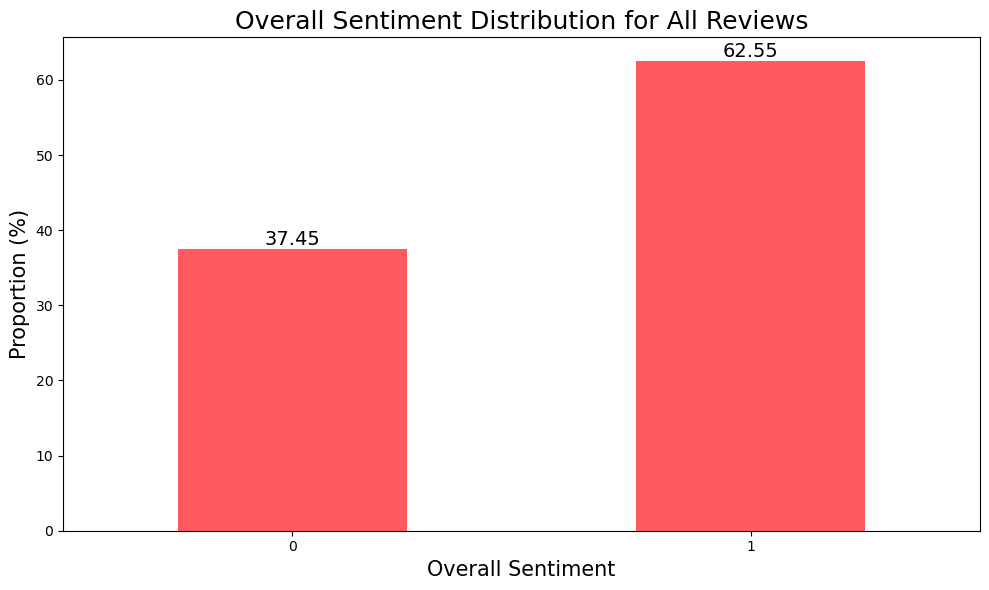

In [11]:
# Create distribution results for our target variable
overall_sentiment_distribution=round(df_reviews_by_listing['Overall_sentiment'].value_counts(normalize=True).sort_index()*100, 2)

# Determine figure size
plt.figure(figsize=(10,6))

# Create barplot
ax = overall_sentiment_distribution.plot.bar(color='#FF5A5F')

# Add labels
plt.title('Overall Sentiment Distribution for All Reviews', fontsize=18)
plt.xlabel('Overall Sentiment', fontsize=15)
plt.ylabel('Proportion (%)', fontsize=15)
plt.bar_label(ax.containers[0], size=14)
plt.xticks(rotation = 360)

plt.tight_layout()  
plt.show()

The current sentiment score distribution (37:63) is not as balanced as it was analysed in the listing level. This imbalance indicates a potential bias in the dataset, with a disproportionate number of reviews having positive sentiments compared to negative sentiments.

To address this issue, we plan to **downsample** reviews with positive sentiments in the next sampling stage. This approach aims to create a more even distribution of the target variable, enhancing the model's ability to generalize across different sentiment categories. However, to avoid potential **data leakage**, we will only perform sampling on the **training** dataset after **Train Test Split**.

We also conclude that this imbalance may be attributed to positive review bias, where guests are more inclined to leave positive reviews. Additionally, the reinforcement effect further amplifies this bias, as the presence of positive reviews may influence subsequent guests to also leave positive reviews.

***

## Train Test Split <a id='a3.4'></a>

The modelling process starts by splitting our dataset into training and testing sets. This procedure is fundamental for the effective evaluation of our model performance.

The training data is implemented upon which our model is built and refined, and the testing data provides the benchmark for assessing the model's predictive performance on unseen data. This ensures us to mitigate the risk of **overfitting**, as our model will not just memorize the data pattern but rather learns to generalize on new, unseen data.

Additionally, it is important that this splitting process must precede any data transformation steps including random sampling, text vectorization and scaling to prevent potential **data leakage**.

In [12]:
# Split test data as 30% of all data, determine random state to make sure every split is the same
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Show the number of rows for training and testing dataset
print(f'The number of rows obtained in the training data is {X_train.shape[0]}, with {X_train.shape[1]} feature columns.')
print(f'The number of rows obtained in the testing data is {X_test.shape[0]}, with {X_train.shape[1]} feature columns.')

The number of rows obtained in the training data is 376561, with 38 feature columns.
The number of rows obtained in the testing data is 94141, with 38 feature columns.


***

## Sampling <a id='a3.3'></a>

Since we have a large training dataset with nearly 330k rows and an imbalanced target variable, we will perform **downsampling** on the training dataset by randomly select a balanced number of rows for both positive labelled rows and negative labelled rows.

We will eventually select 3% of the original training dataset.

In [14]:
# Define function that can perform downsampling on training data and make it perfectly balanced
def downsample_train(X_train, y_train, target, proportion):
    '''
    Function only works on target variable as binary column. 
    
    Returns downsampled X_train and y_train which
    has downsampled to specified proportion of original
    data, also makes sure y_train is balanced
    
    PARAMETERS:
    - X_train: dataframe, splitted feature training data
    - y_train: dataframe, splitted farget training data
    - target: str, target variable name
    - proportion: float, specified downsample proportion of total training data
    
    RETURNS:
    - X_train_sample: Downsampled X_train
    - y_train_sample: Downsampled y_train
    
    '''
    # Specify number of rows for each class 
    num_rows_each = round(proportion*X_train.shape[0]/2)
    
    # Temporarily concatenate X_train and y_train back to dataframe format
    df_train = pd.concat([X_train, y_train], axis=1)
    
    # Split classes
    df_pos = df_train[df_train[target] == 1]
    df_neg = df_train[df_train[target] == 0]
    
    # Resplit X and y for both two classes
    X_pos, y_pos = df_pos.drop(target, axis=1), df_pos[target]
    X_neg, y_neg = df_neg.drop(target, axis=1), df_neg[target]
    
    # Select randomized samples from each class
    X_pos_sample, y_pos_sample = resample(X_pos, y_pos, random_state=123, n_samples = num_rows_each, replace=False, stratify=y_pos)
    X_neg_sample, y_neg_sample = resample(X_neg, y_neg, random_state=123, n_samples = num_rows_each, replace=False, stratify=y_neg)
    
    # Concatenate back downsampled data
    X_train_sample = pd.concat([X_pos_sample, X_neg_sample], axis=0)
    y_train_sample = pd.concat([y_pos_sample, y_neg_sample], axis=0)
    
    return X_train_sample, y_train_sample

In [15]:
# Return downsampled training data
X_train_sample, y_train_sample = downsample_train(X_train, y_train, 'Overall_sentiment', 0.03)

In [16]:
# Check for current target variable distribution
print('The current proportion of each sentiment score class is (%)')
print((y_train_sample.value_counts(normalize=True))*100)
print('\n--------------------------------------------\n')
print(f'The current number of rows in the training data is {X_train_sample.shape[0]}')

The current proportion of each sentiment score class is (%)
1    50.0
0    50.0
Name: Overall_sentiment, dtype: float64

--------------------------------------------

The current number of rows in the training data is 11296


Thus we have downsampled our training data nearly 330k (376561) rows to just over 10k (11296), and we also obtained a balanced training data. We will hope that this will potentially improve our model performance and also help the models to generalize well in the testing set.

***

## Helper Function <a id='a3.5'></a>

Our dataset includes multiple non-review features, in the later text vectorization stage, it is not necessary for these columns to be processed by the vectorizers. Hence, we require a helper function to handle these numerical columns separately, and generate a column transformer based on our selection on different text vectorizers including `CountVectorizer` and `TfidfVectorizer`. 

Additionally, the numerical features in our dataset vary across different ranges, necessitating the scaling of data during the modeling stage. However, the text vectorizers will return a sparse matrix after transformation, while scalers like `StandardScaler` and `MinMaxScaler` require a dense array as input. Hence, we'll also need a function to convert the sparse matrix into a dense array.

This code is borrowed from [Allistair Cota](https://github.com/allistaircota/rate_my_restaurant/blob/main/notebooks/NB3-Modelling.ipynb).

| Vectorizer  | Scaler| 
|:-------:|:--------:|
|[TF-IDF Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) |  [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)  |
|[Count-Vectorizer](https://en.wikipedia.org/wiki/Bag-of-words_model)  |[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) |

In [17]:
# Extract numerical column names
numeric_columns = X.select_dtypes(exclude='object').columns.to_list()

def define_col_trans(input_text, vectorizer):
    '''
    Returns a ColumnTransformer which first performs a 
    passthrough on the numeric columns, then applies
    a vectorizer on the `text` column
    
    PARAMETERS:
    - input_text: str, to name the vectorizer tuple
    - vectorizer: Sklearn text vectorizer
    
    RETURNS:
    - col_trans: sklearn ColumnTransformer
    
    '''
    
    col_trans = ColumnTransformer([
        ('numeric', 'passthrough', numeric_columns), # numerical_columns defined above
        (input_text, vectorizer, 'comments') # 'comments' as review text feature column
    ])
    
    return col_trans

def convert_to_array(sparse_matrix):
    '''
    Converts sparse matrix to dense array
    
    PARAMETERS:
    - sparse_matrix: scipy.sparse.csr_matrix or numpy array
    
    RETURNS:
    - If sparse_matrix is not a scipy.sparse.csr_matrix,
      sparse_matrix is returned. Else, returns the dense array
      form of sparse_matrix.
    
    '''
    
    if type(sparse_matrix) == csr_matrix:
    
        return sparse_matrix.toarray()
    
    else:
        return sparse_matrix

#### Text vectorizer list

In [18]:
# Define column transformers
ct_bow = define_col_trans('ct_bow',  CountVectorizer(max_df=0.95, min_df=5, tokenizer=customized_tokenizer))
ct_tfidf = define_col_trans('ct_tfidf',  TfidfVectorizer(max_df=0.95, min_df=5, tokenizer=customized_tokenizer))

***

# Baseline Model <a id='a4'></a>

As we are developing the best performed models for predicting the class of guest sentiments, it is crucial to establish a baseline model for comparison. We will utilise a **Dummy Classifier** model, which makes predictions without accessing dataset features, essentially performing random guessing. By establishing this baseline, we can decide that any model performing worse than the baseline model will not proceed to further analysis.

**Run Time**: 3mins 30s

In [34]:
# Vectorize data using Bag of Words Vectorizer
bow_vec = CountVectorizer(max_features = 500, # Only obtain top 500 features based on vectorizer results
                            min_df=5, # Feature occurency should be bigger than 5 in the corpus
                            tokenizer=customized_tokenizer)

# Fit and transform on the vectorizer to training data
X_train_tfidf_d = bow_vec.fit_transform(X_train_sample['comments']).toarray()

# Transform on both training data and testing data
X_test_tfidf_d = bow_vec.transform(X_test['comments']).toarray()

# Reset Index before concatenating
X_train_sample_reset_index = X_train_sample.reset_index(drop=True)
X_test_reset_index = X_test.reset_index(drop=True)

# Merge the resulting arrays with the original numeric features
X_train_tfidf_d_transformed = pd.concat([X_train_sample_reset_index.drop(['comments'], axis=1),
                                         pd.DataFrame(X_train_tfidf_d, columns=[i for i in bow_vec.get_feature_names_out()])], axis=1)

X_test_tfidf_d_transformed = pd.concat([X_test_reset_index.drop(['comments'], axis=1), 
                                        pd.DataFrame(X_test_tfidf_d, columns=[i for i in bow_vec.get_feature_names_out()])], axis = 1)

# Print shape of the vectorized training feature data
print(f'X_train_transfomed_dummy : {X_train_tfidf_d_transformed.shape}')

X_train_transfomed_dummy : (11296, 537)
CPU times: total: 3min 30s
Wall time: 3min 31s


In [36]:
# # Dummy Classifier - Baseline Model
# Instantiate Dummy Classifier
dummy_classifier = DummyClassifier()

# Fit the Dummy Classifier on Training data
dummy_classifier.fit(X_train_tfidf_d_transformed, y_train_sample)

# Predict the fitted model on Testing Data
y_predict_d = dummy_classifier.predict(X_test_tfidf_d_transformed)

# Print F1 score
print(f'The Accuracy Score (%) for the Baseline Model is: {round(accuracy_score(y_test, y_predict_d)*100, 2)} %')

The Accuracy Score (%) for the Baseline Model is: 37.38 %


#### Classification report <a id='a4.1'></a>

In [37]:
# Generate classification report to see specific classification evaluation metrics scores
baseline_report = classification_report(y_test, y_predict_d)
print(baseline_report)

              precision    recall  f1-score   support

           0       0.37      1.00      0.54     35192
           1       0.00      0.00      0.00     58949

    accuracy                           0.37     94141
   macro avg       0.19      0.50      0.27     94141
weighted avg       0.14      0.37      0.20     94141



Based on the findings from the classification report, the model classification accuracy score achieved by the dummy classifier is **37.38%**. This baseline performance indicates that future models should aim to surpass this threshold to be considered effective. Therefore, our goal for future models is to achieve an accuracy score higher than 38%, indicating improved predictive capability and accuracy in classifying sentiments. 

**Note**: This result is reflected by the actual proportion of negative sentiments in the testing dataset as Dummy Classifier takes random guesses.

***

# Modelling <a id='a5'></a>

After completing data cleaning, pre-processing, and model setup stages, we are ready to train models and make predictions. To determine the best-performing model, we will utilize **GridSearchCV** to find the optimal model with the best hyperparameters. Machine learning metrics and models to be used in our modeling process include:

- Text Vectorizer: Bag of Words, TF-IDF
- Scaler: StandardScaler
- Models: Logistic Regression, Decision Tree Classifier, Random Forest Classifier.

Note that for performance purposes, we will be vectorizing the datasets outside of grid search. We will then fit combinations of models to the training data that has been transformed by two types of text vectorizations. During the fitting process, **5-fold cross-validation** will be performed to improve model performance and interpretability. Finally, the model with the highest average validation F1 score will be selected and evaluated at the end of each GridSearch.

In [42]:
# Fit and transform on training data, and transform on testing data: Bag of Words Vectorizer
X_train_ct_bow = ct_bow.fit_transform(X_train_sample)
X_test_ct_bow = ct_bow.transform(X_test)

# Fit and transform on training data, and transform on testing data: TF-IDF Vectorizer
X_train_ct_tfidf= ct_tfidf.fit_transform(X_train_sample)
X_test_ct_tfidf = ct_tfidf.transform(X_test)

## GridSearch_1: General Sweep <a id='a5.1'></a>

During the first GridSearch, we will be searching for optimal hyperparameters over wide range implementing on the **Logistic Regresion** and **Decision Tree Classifier**. This GridSearch will be run and fitted on two vectorized training sets defined above and we will evaluate the model performances with a brief summary. The selections of models and parameters are summarized below:

|    Models   |    Hyperparameters   |   Ranges/Options  |
|:-------------:|:-------------:|:-------------:|
|    **TfidfVectorizer**     |     max_df   |    0.95     |
|                  |     min_df  |    5       |
|       **CountVectorizer**           |     max_df  |    0.95       |
|                  |     min_df  |    5       |
|    **Logistic Regression**     |    C     |    0.001, 0.01, 0.1, 1, 10    |
|         |    penalty     |    'none', 'l2'     | 
|    **Decision Tree**     |     max_depth    |     2, 8, 32, 64, 128    |
|                 |    min_samples_leaf     |     2, 4, 8    |
|                 |     min_samples_split    |     2, 4, 8    |
|                 |     criterion    |     'gini', 'entropy'    |

In [43]:
%%time

# First GridSearch

# Define base pipeline
pipeline_1 = Pipeline([
    ('sparse_to_dense', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

# Instantiate Pipeline with grid of parameters
grid_param_1 = [
    
    # Logistic Regression
    {
        'model'              : [LogisticRegression()],
        'model__C'           : [0.001, 0.01, 0.1, 1, 10], # C parameter to control penalty weights
        'model__penalty'     : ['none', 'l2'], # Control penalty types, l1: Lasso, l2: Ridge
        'model__random_state': [123], # Control gradient descent starting point
        'model__max_iter'    : [10000] # Make sure model iterates
    },
    
    # Decision Tree Classifier
    {
        'model'                   : [DecisionTreeClassifier()],
        'model__max_depth'        : [2, 8, 32, 64, 128], # Control number of tree splits/depth
        'model__min_samples_leaf' : [2, 4, 8], # Control minimum number of samples at a leaf node
        'model__min_samples_split': [2, 4, 8], # Control minimum number of samples split at a leaf node
        'model__criterion'        : ['gini', 'entropy'], # Control the function to measure the quality of a split
        'model__random_state'     :[123] # Control randomness of the estimator
    }
]

# Use GridSearch
grid_1 = GridSearchCV(estimator=pipeline_1, # Define GridSearch estimator pipeline
                     param_grid=grid_param_1, # Define parameter grid
                     cv=5, # Define 5-fold cross-validation
                     n_jobs=-2) 

# Fit the grid on training data
fittedgrid_1_bow = grid_1.fit(X_train_ct_bow, y_train_sample)
fittedgrid_1_tfidf = grid_1.fit(X_train_ct_tfidf, y_train_sample)

# Save GridSearch_1
grid_model_1_bow = fittedgrid_1_bow
grid_model_1_tfidf = fittedgrid_1_tfidf

CPU times: total: 14.9 s
Wall time: 49min 11s


#### Selected model results with Bag of Words transformed data 

In [54]:
print('\n--------------------\n')
print(fittedgrid_1_bow.best_estimator_)

# Print Crossvalidated Score
print('\n--------------------\n')
print(f'Best Model Train Score (%): {round(fittedgrid_1_bow.score(X_train_ct_bow, y_train_sample)*100.00, 2)}') 

# Print Testing Score
print('\n--------------------\n')
print(f'Best Model Train Score (%): {round(fittedgrid_1_bow.score(X_test_ct_bow, y_test)*100, 2)}') 


--------------------

Pipeline(steps=[('sparse_to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function convert_to_array at 0x000001E792BC9440>)),
                ('scaler', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=32,
                                        min_samples_leaf=2,
                                        random_state=123))])

--------------------

Best Model Train Score (%): 97.35

--------------------

Best Model Train Score (%): 93.62


#### Selected model results with TF-IDF transformed data 

In [55]:
print('\n--------------------\n')
print(fittedgrid_1_tfidf.best_estimator_)

# Print Score
print('\n--------------------\n')
print(f'Best Model Train Score (%): {round(fittedgrid_1_tfidf.score(X_train_ct_tfidf, y_train_sample)*100.00, 2)}') 

# Print Testing Score
print('\n--------------------\n')
print(f'Best Model Train Score (%): {round(fittedgrid_1_tfidf.score(X_test_ct_tfidf, y_test)*100, 2)}') 


--------------------

Pipeline(steps=[('sparse_to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function convert_to_array at 0x000001E792BC9440>)),
                ('scaler', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=32,
                                        min_samples_leaf=2,
                                        random_state=123))])

--------------------

Best Model Train Score (%): 99.27

--------------------

Best Model Train Score (%): 94.43


In [70]:
best_bow = fittedgrid_1_bow.best_estimator_

features = list(zip(ct_bow.get_feature_names_out(), best_bow.named_steps['model'].feature_importances_))

sorted_features = sorted(features, key=lambda x: x[1], reverse=True)

top_feature_names = [feature[0] for feature in sorted_features[:1000] if feature[0][0]=='c']
print("Top feature names based on feature importance in the best decision tree classifier:")
for feature_name in top_feature_names:
    print(feature_name)

Top feature names based on feature importance in the best decision tree classifier:
ct_bow__lovely
ct_bow__welcome
ct_bow__wonderful
ct_bow__touch
ct_bow__clean
ct_bow__stay
ct_bow__location
ct_bow__recommend
ct_bow__home
ct_bow__place
ct_bow__easy
ct_bow__nice
ct_bow__thank
ct_bow__wendy
ct_bow__centre
ct_bow__space
ct_bow__quiet
ct_bow__host
ct_bow__time
ct_bow__kind
ct_bow__bite
ct_bow__work
ct_bow__great
ct_bow__spotlessly
ct_bow__close
ct_bow__neighborhood
ct_bow__help
ct_bow__need
ct_bow__get
ct_bow__beautiful
ct_bow__spend
ct_bow__comfy
ct_bow__really
ct_bow__street
ct_bow__stairs
ct_bow__day
ct_bow__travel
ct_bow__fiona
ct_bow__anyone
ct_bow__meadows
ct_bow__high
ct_bow__stun
ct_bow__us
ct_bow__prompt
ct_bow__fantastic
ct_bow__spacious
ct_bow__furnish
ct_bow__leave
ct_bow__car
ct_bow__end
ct_bow__city
ct_bow__also
ct_bow__back
ct_bow__communication
ct_bow__around
ct_bow__highly
ct_bow__ideal
ct_bow__ahead
ct_bow__transport
ct_bow__one
ct_bow__bright
ct_bow__equip
ct_bow__weeken

In [69]:
best_tfidf = fittedgrid_1_tfidf.best_estimator_

features = list(zip(ct_tfidf.get_feature_names_out(), best_tfidf.named_steps['model'].feature_importances_))

sorted_features = sorted(features, key=lambda x: x[1], reverse=True)

top_feature_names = [feature[0] for feature in sorted_features[:1000] if feature[0][0]=='c']
print("Top feature names based on feature importance in the best decision tree classifier:")
for feature_name in top_feature_names:
    print(feature_name)

Top feature names based on feature importance in the best decision tree classifier:
ct_tfidf__lovely
ct_tfidf__welcome
ct_tfidf__wonderful
ct_tfidf__touch
ct_tfidf__clean
ct_tfidf__stay
ct_tfidf__location
ct_tfidf__recommend
ct_tfidf__home
ct_tfidf__place
ct_tfidf__easy
ct_tfidf__nice
ct_tfidf__thank
ct_tfidf__wendy
ct_tfidf__centre
ct_tfidf__space
ct_tfidf__quiet
ct_tfidf__host
ct_tfidf__time
ct_tfidf__kind
ct_tfidf__bite
ct_tfidf__work
ct_tfidf__great
ct_tfidf__spotlessly
ct_tfidf__close
ct_tfidf__neighborhood
ct_tfidf__help
ct_tfidf__need
ct_tfidf__get
ct_tfidf__beautiful
ct_tfidf__spend
ct_tfidf__comfy
ct_tfidf__really
ct_tfidf__street
ct_tfidf__stairs
ct_tfidf__day
ct_tfidf__travel
ct_tfidf__fiona
ct_tfidf__anyone
ct_tfidf__meadows
ct_tfidf__high
ct_tfidf__stun
ct_tfidf__us
ct_tfidf__prompt
ct_tfidf__fantastic
ct_tfidf__spacious
ct_tfidf__furnish
ct_tfidf__leave
ct_tfidf__car
ct_tfidf__end
ct_tfidf__city
ct_tfidf__also
ct_tfidf__back
ct_tfidf__communication
ct_tfidf__around
ct_tfi

#### GridSearch_1 Result Summary

***

## GridSearch_2 : Narrowed Range with ensemble learnings

In [ ]:
%%time

# Second GridSearch

# Define base pipeline
pipeline_1 = Pipeline([
    ('sparse_to_dense', FunctionTransformer(convert_to_array, accept_sparse=True)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

# Instantiate Pipeline with grid of parameters
grid_param_2 = [
    
    # Logistic Regression
    {
        'model'              : [LogisticRegression()],
        'model__C'           : [0.001, 0.01, 0.1, 1, 10], # C parameter to control penalty weights
        'model__penalty'     : ['none', 'l2'], # Control penalty types, l1: Lasso, l2: Ridge
        'model__random_state': [123], # Control gradient descent starting point
        'model__max_iter'    : [10000] # Make sure model iterates
    },
    
    # Decision Tree Classifier
    {
        'model'                   : [DecisionTreeClassifier()],
        'model__max_depth'        : [2, 8, 32, 64, 128], # Control number of tree splits/depth
        'model__min_samples_leaf' : [2, 4, 8], # Control minimum number of samples at a leaf node
        'model__min_samples_split': [2, 4, 8], # Control minimum number of samples split at a leaf node
        'model__criterion'        : ['gini', 'entropy'], # Control the function to measure the quality of a split
        'model__random_state'     :[123] # Control randomness of the estimator
    },
    
    # Random Forest
    {
        'model'                   : [RandomForestClassifier()],
        'model__n_estimators'     : [10,20,30,40,50], # Control number of trees in the forest
        'model__max_depth'        : [2, 8, 32, 64, 128], # Control number of tree splits/depth
        'model__min_samples_leaf' : [2,3,4], # Control minimum number of samples at a leaf node
        'model__min_samples_split': [1,2,3], # Control minimum number of samples split at a leaf node
        'model__criterion'        : ['gini', 'entropy'], # Control the function to measure the quality of a split
        'model__random_state'     :[123] # Control randomness of the estimator  
    }  
]

# Use GridSearch
grid_1 = GridSearchCV(estimator=pipeline_1, # Define GridSearch estimator pipeline
                     param_grid=grid_param_1, # Define parameter grid
                     cv=5, # Define 5-fold cross-validation
                     scoring='f1', # Define GridSearch evaluation metric to be f1 score
                     n_jobs=-2)

# Fit the grid on training data
fittedgrid_1_bow = grid_1.fit(X_train_ct_bow, y_train)
fittedgrid_1_tfidf = grid_1.fit(X_train_ct_tfidf, y_train)

# Save GridSearch_1
grid_model_1_bow = fittedgrid_1_bow
grid_model_1_tfidf = fittedgrid_1_tfidf